In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [5]:
n = 1000
min_f = 0
max_f = 3
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=3,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 3)


In [6]:
x_train.shape

(1000, 100, 3, 1)

In [7]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 3, 1), 900]

In [8]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 3)


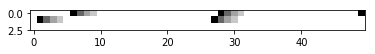

m (50, 3)


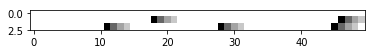

m (50, 3)


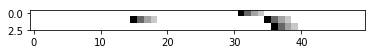

In [9]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 3, 1)

In [11]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [58]:
def encoder(input_size, dropout=0.05):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='elu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     #     x = AveragePooling2D((2, 2))(x)
#     h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dropout(dropout)(h) # uncomment when using larger batches

    h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [59]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 100, 3)       0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 50, 32)       224         reshape_5[0][0]                  
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 50, 32)       2080        conv1d_7[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (

In [60]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [61]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [62]:
def list_decoders(output_size, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_size
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
#     decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]

#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolve & Pool
    
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()] # note that [].append != [] = []
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [63]:
decoders = list_decoders(input_shape)

In [64]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [65]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 211908      input_4[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 300)          900         lambda_3[0][0]                   
__________

In [67]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.2)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_6" during training.
  # This is added back by InteractiveShellApp.init_path()


In [77]:
batch_size = 100
epochs = 50
params = {'batch_size': batch_size, 'return_y': False}

In [78]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [79]:
x_train.shape

(900, 100, 3, 1)

In [80]:
m = 5
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>\n' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 113.7614
 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 112.2560
 Batch 2/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 112.8939
 Batch 3/9
Epoch 1/1
5/5 [==============================] - 0s 4ms/step - loss: 110.2373
 Batch 4/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 108.5575
 Batch 5/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 105.2845
 Batch 6/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 105.1407
 Batch 7/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 103.4657
 Batch 8/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 111.1152
 Batch 9/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 101.4928

[Epoch 1/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [===========


[Epoch 9/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 72.9220
 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 71.7249
 Batch 2/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 73.2244
 Batch 3/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 80.0607
 Batch 4/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 77.8314
 Batch 5/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 70.9997
 Batch 6/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 76.9878
 Batch 7/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 77.2467
 Batch 8/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 72.8931
 Batch 9/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 64.4167

[Epoch 10/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 1ms/step - loss: 59.8568
 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 66.5236
 Batch 2/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 69.4642
 Batch 3/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 71.7453
 Batch 4/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 62.5123
 Batch 5/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 65.7518
 Batch 6/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 71.3011
 Batch 7/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 69.0412
 Batch 8/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 66.8370
 Batch 9/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 69.1184

[Epoch 19/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 67.5091
 Ba

5/5 [==============================] - 0s 3ms/step - loss: 71.6036
 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 65.1624
 Batch 2/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 62.4012
 Batch 3/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 64.1104
 Batch 4/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 61.9008
 Batch 5/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 61.9154
 Batch 6/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 63.0589
 Batch 7/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 65.1127
 Batch 8/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 67.5376
 Batch 9/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 62.5923

[Epoch 28/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 64.6853
 Batch 1/9
Epoch 1/1
5/5

 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 63.4776
 Batch 2/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 63.2111
 Batch 3/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 62.4064
 Batch 4/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 58.9695
 Batch 5/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 60.2217
 Batch 6/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 66.5948
 Batch 7/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 60.4939
 Batch 8/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 58.1074
 Batch 9/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 57.4658

[Epoch 37/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 60.9747
 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 62.7171
 Ba

5/5 [==============================] - 0s 2ms/step - loss: 60.9703
 Batch 2/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 56.3730
 Batch 3/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 53.0363
 Batch 4/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 57.6581
 Batch 5/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 59.1376
 Batch 6/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 57.2524
 Batch 7/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 60.6531
 Batch 8/9
Epoch 1/1
5/5 [==============================] - 0s 2ms/step - loss: 57.9950
 Batch 9/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 55.7592

[Epoch 46/50] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 62.1938
 Batch 1/9
Epoch 1/1
5/5 [==============================] - 0s 4ms/step - loss: 59.3142
 Batch 2/9
Epoch 1/1
5/5

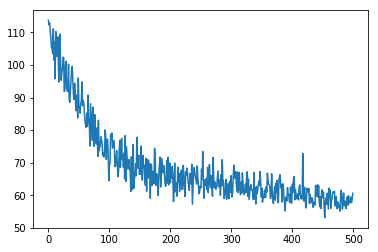

In [81]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (50, 3)


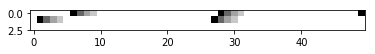

m (50, 3)


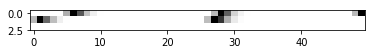

m (50, 3)


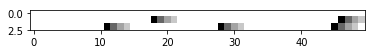

m (50, 3)


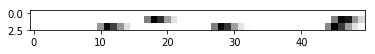

m (50, 3)


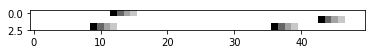

m (50, 3)


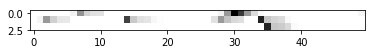

In [82]:
i = 0
j = 1
k = -1
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [83]:
x.shape

(10, 100, 3, 1)

m (30, 3)


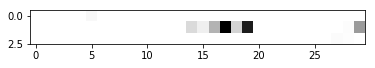

In [88]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 3)


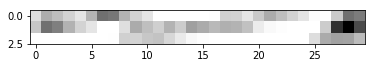

In [87]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder
A model to project inputs on the latent space

In [91]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [92]:
x_test.shape

(100, 100, 3, 1)

In [93]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

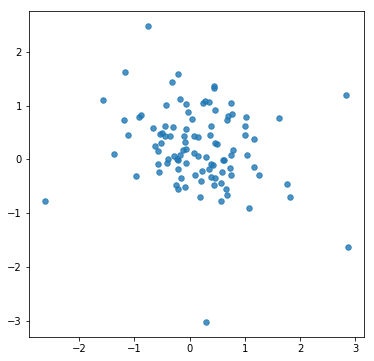

In [235]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.8, s=30) # c=y_test, 

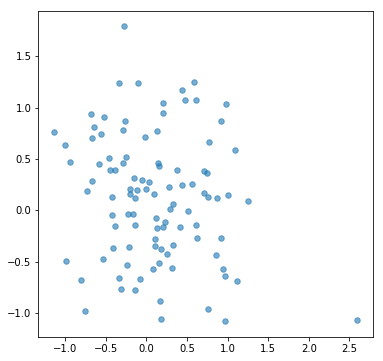

In [237]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [97]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [36]:
# x_decoded[0].reshape(150,3)

In [109]:
x_train.shape

(900, 100, 3, 1)

In [135]:
margin_top * n

15

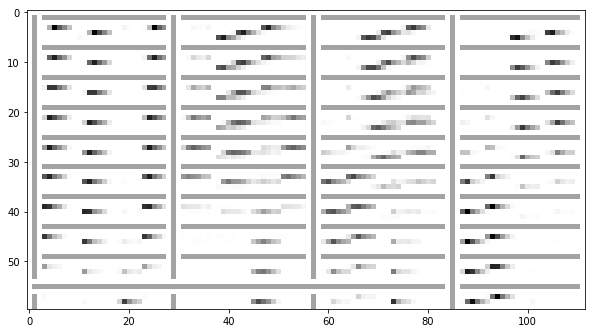

In [231]:
# display a 2D manifold of output samples
n = 10
m = 4
size1 = x_train.shape[2]
size2 = 25 # crop x_train.shape[1]
margin_top = 1
margin_left = 1
margin_y, margin_x = margin_top * 3 * n, margin_left * 3 * m
figure = np.zeros((size1 * n + margin_y, size2 * m + margin_x))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, m))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # z_sample = np.array([[yi, xi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        sample = x_decoded[0,:size2].reshape((size2, size1)).transpose()
        sample.reshape(size1, size2)
        # coordinates of the current sample
        a,b,c,d = i * size1, (i + 1) * size1, j * size2, (j + 1) * size2
        a += i * margin_top * 3
        b += i * margin_top * 3
        c += j * margin_left * 3
        d += j * margin_left * 3
        figure[a, :] = 0
        figure[a+1, 1:-1] = 0.3
        figure[a+2, :] = 0
        figure[:, c] = 0
        figure[1:, c+1] = 0.3
        figure[:, c+2] = 0
        a,b,c,d = a+3,b+3,c+3,d+3
        figure[a:b,c:d] = sample

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray_r')
plt.show()

In [ ]:
# display a 2D manifold of output samples
n = 10
m = 1
size1 = x_train.shape[2]
size2 = 30 # crop x_train.shape[1]
margin_top = 1
margin_left = 1
margin_y, margin_x = margin_top * 3, margin_left * 3
figure = np.zeros((size1 * n + margin_y, size2 * m + margin_x))
figure = np.zeros((size1 * n + margin_y, size2 * m))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, m))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # z_sample = np.array([[yi, xi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        sample = x_decoded[0,:size2].reshape((size2, size1)).transpose()
        sample.reshape(size1, size2)
        # coordinates of the current sample
        a,b,c,d = i * size1, (i + 1) * size1, j * size2, (j + 1) * size2
        a += i * margin_top * 3
        b += i * margin_top * 3
        
        figure[a, :] = 0
        figure[a+1, :] = 0.3
        figure[a+2, :] = 0
        a += 3
        b += 3
        figure[a:b,c:d] = sample

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray_r')
plt.show()